# Data Exploration and Sanity Checks

This notebook provides initial exploration of the collected Reddit and Hacker News data.

## Objectives
1. Load and examine collected data
2. Verify data quality and completeness
3. Explore score distributions and patterns
4. Identify potential data issues
5. Generate summary statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from datetime import datetime

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

%matplotlib inline

## 1. Load Data

In [2]:
# Find all data files
data_dir = Path('../data')
reddit_files = list(data_dir.glob('reddit_*.parquet'))
hn_files = list(data_dir.glob('hackernews_*.parquet'))

print(f"Found {len(reddit_files)} Reddit files and {len(hn_files)} HN files")

# Load Reddit data if available
if reddit_files:
    reddit_data = []
    for file in reddit_files:
        if 'snapshots' not in str(file):
            df = pd.read_parquet(file)
            reddit_data.append(df)
    
    if reddit_data:
        reddit_df = pd.concat(reddit_data, ignore_index=True)
        print(f"Reddit data: {len(reddit_df)} posts")
    else:
        reddit_df = None
else:
    reddit_df = None

# Load HN data if available
if hn_files:
    hn_data = []
    for file in hn_files:
        if 'snapshots' not in str(file):
            df = pd.read_parquet(file)
            hn_data.append(df)
    
    if hn_data:
        hn_df = pd.concat(hn_data, ignore_index=True)
        print(f"HN data: {len(hn_df)} stories")
    else:
        hn_df = None
else:
    hn_df = None

Found 5 Reddit files and 3 HN files
Reddit data: 1315 posts
HN data: 432 stories


## 2. Data Quality Checks

In [3]:
def check_data_quality(df, platform_name):
    """Perform data quality checks on a platform's data."""
    print(f"\n=== {platform_name} Data Quality ===")
    print(f"Shape: {df.shape}")
    print(f"\nMissing values:")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    
    print(f"\nDuplicate posts: {df.duplicated(subset=['post_id']).sum()}")
    
    print(f"\nScore statistics:")
    print(df['score'].describe())
    
    print(f"\nTitle length statistics:")
    title_lengths = df['title'].str.len()
    print(title_lengths.describe())
    
    # Check for extreme values
    print(f"\nPotential outliers:")
    print(f"Very high scores (>1000): {(df['score'] > 1000).sum()}")
    print(f"Zero scores: {(df['score'] == 0).sum()}")
    print(f"Very long titles (>200 chars): {(title_lengths > 200).sum()}")
    print(f"Very short titles (<10 chars): {(title_lengths < 10).sum()}")

# Check Reddit data
if reddit_df is not None:
    check_data_quality(reddit_df, "Reddit")

# Check HN data
if hn_df is not None:
    check_data_quality(hn_df, "Hacker News")


=== Reddit Data Quality ===
Shape: (1315, 60)

Missing values:
title_length            888
title_words             888
title_chars_per_word    888
has_question            888
has_exclamation         888
punctuation_count       888
all_caps_words          888
capitalization_ratio    888
number_count            888
has_numbers             888
sentiment_compound      888
sentiment_positive      888
sentiment_negative      888
sentiment_neutral       888
flesch_kincaid_grade    888
avg_word_length         888
type_token_ratio        888
clickbait_keywords      888
clickbait_patterns      888
has_clickbait           888
person_entities         888
org_entities            888
date_entities           888
total_entities          888
hour_of_day             888
is_morning              888
is_afternoon            888
is_evening              888
is_night                888
day_of_week             888
is_weekend              888
is_monday               888
is_friday               888
age_hours   

## 3. Score Distribution Analysis

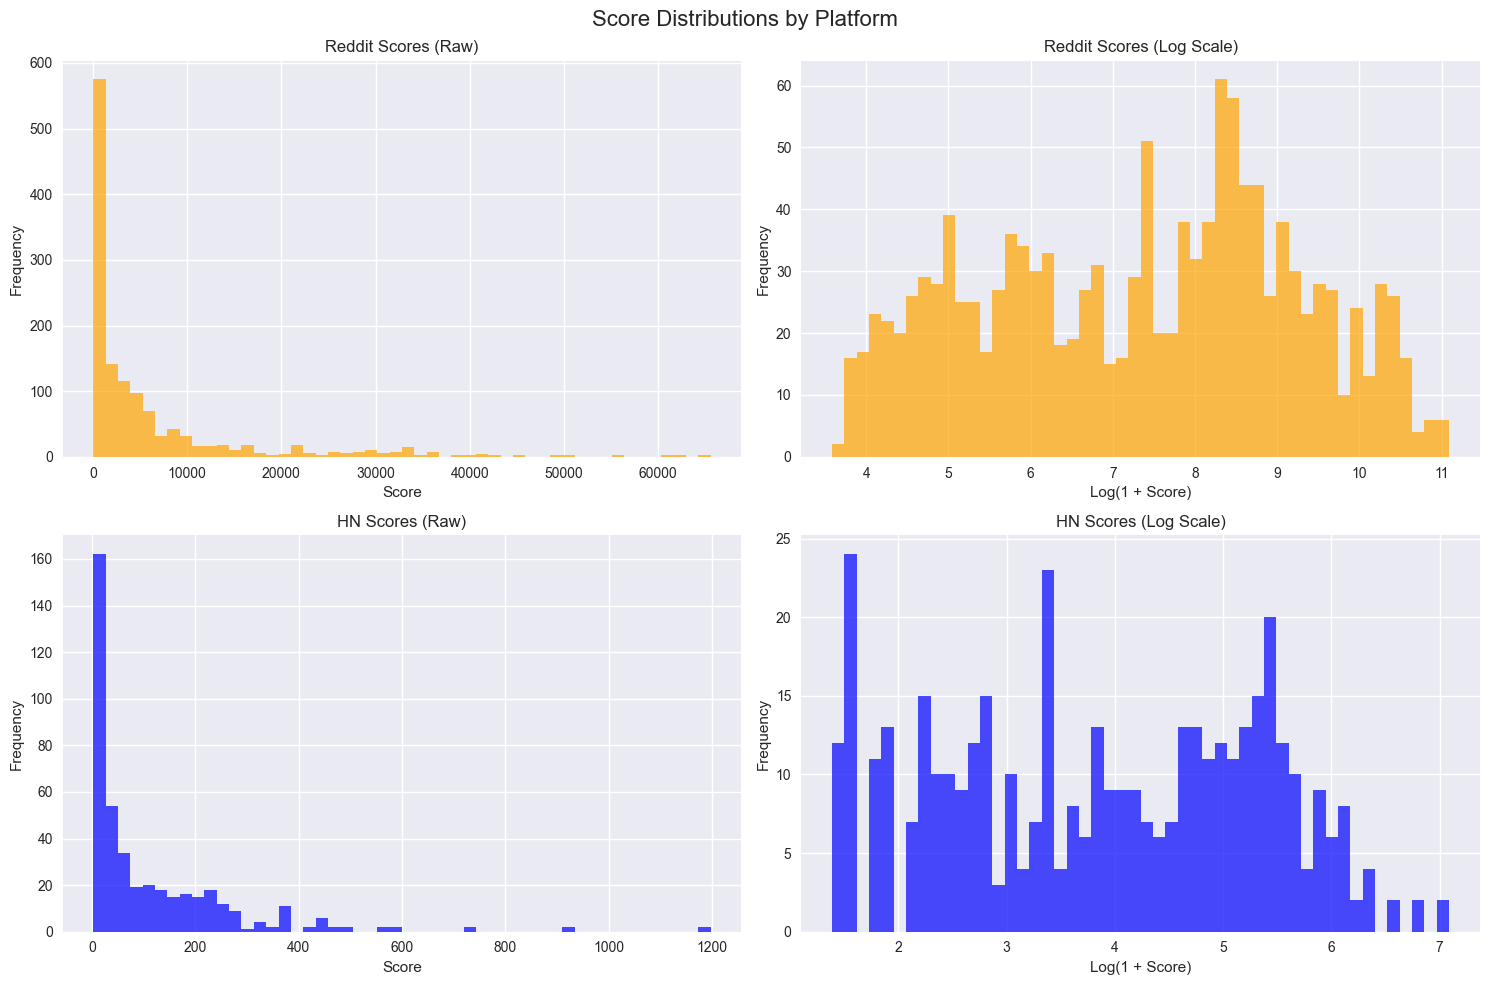

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Score Distributions by Platform', fontsize=16)

# Reddit score distribution
if reddit_df is not None:
    # Raw scores
    axes[0, 0].hist(reddit_df['score'], bins=50, alpha=0.7, color='orange')
    axes[0, 0].set_title('Reddit Scores (Raw)')
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Frequency')
    
    # Log scores
    log_scores = np.log1p(reddit_df['score'])
    axes[0, 1].hist(log_scores, bins=50, alpha=0.7, color='orange')
    axes[0, 1].set_title('Reddit Scores (Log Scale)')
    axes[0, 1].set_xlabel('Log(1 + Score)')
    axes[0, 1].set_ylabel('Frequency')

# HN score distribution
if hn_df is not None:
    # Raw scores
    axes[1, 0].hist(hn_df['score'], bins=50, alpha=0.7, color='blue')
    axes[1, 0].set_title('HN Scores (Raw)')
    axes[1, 0].set_xlabel('Score')
    axes[1, 0].set_ylabel('Frequency')
    
    # Log scores
    log_scores = np.log1p(hn_df['score'])
    axes[1, 1].hist(log_scores, bins=50, alpha=0.7, color='blue')
    axes[1, 1].set_title('HN Scores (Log Scale)')
    axes[1, 1].set_xlabel('Log(1 + Score)')
    axes[1, 1].set_ylabel('Frequency')

# Remove empty subplots
if reddit_df is None:
    axes[0, 0].set_visible(False)
    axes[0, 1].set_visible(False)
if hn_df is None:
    axes[1, 0].set_visible(False)
    axes[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

## 4. Temporal Patterns

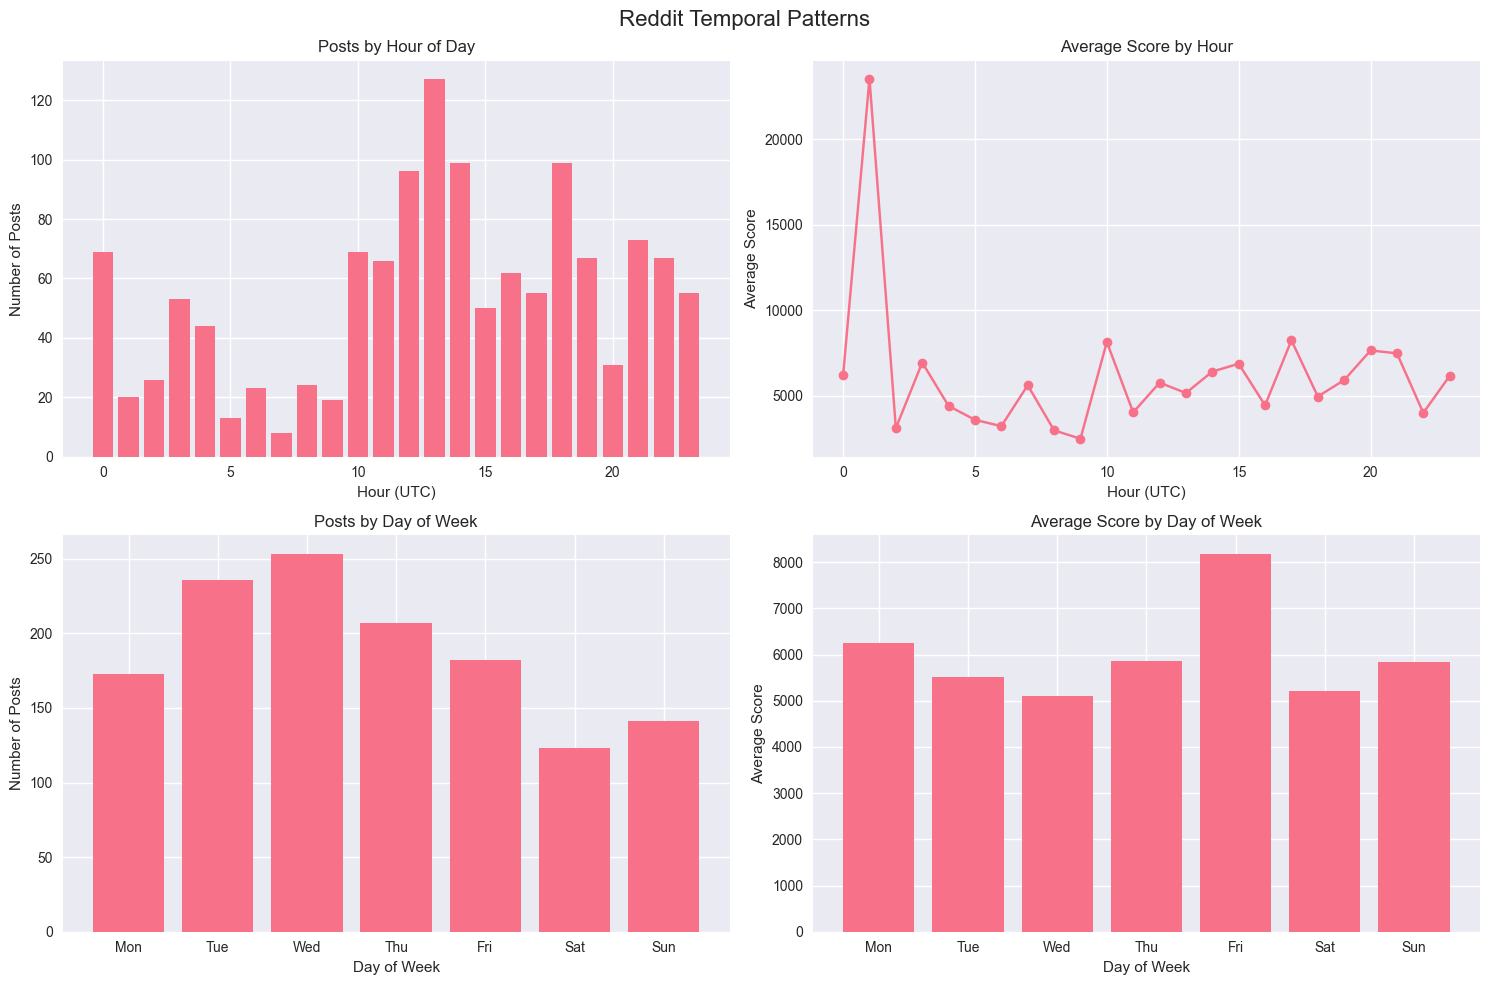

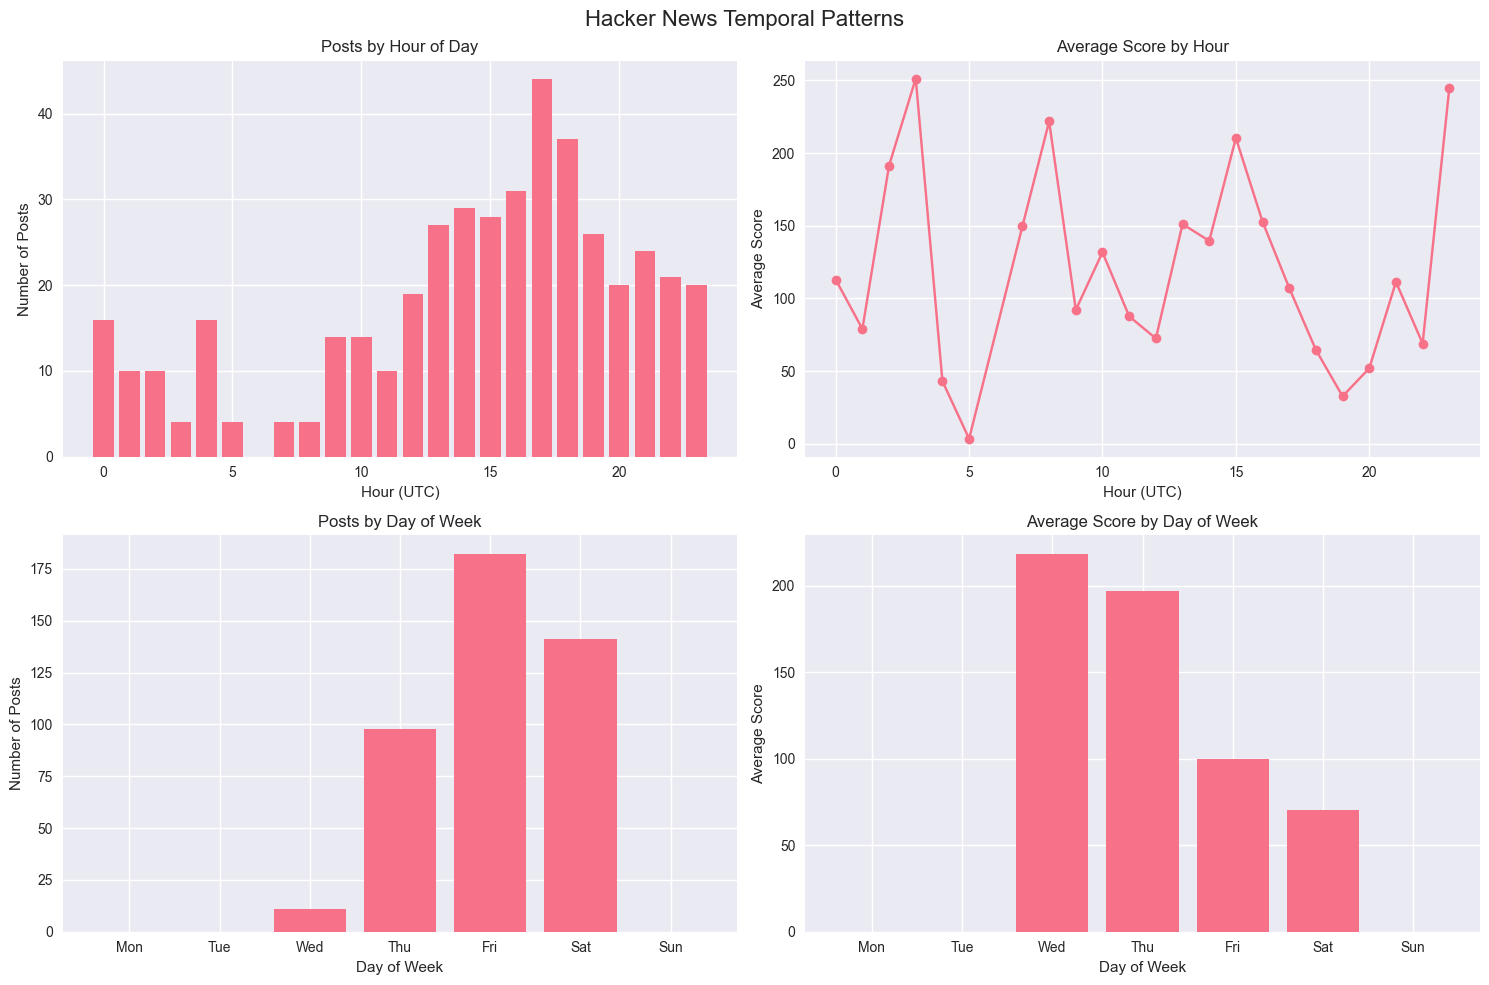

In [5]:
def analyze_temporal_patterns(df, platform_name):
    """Analyze posting and scoring patterns over time."""
    # Convert timestamp to datetime
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['created_timestamp'], unit='s')
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{platform_name} Temporal Patterns', fontsize=16)
    
    # Posts by hour
    hourly_counts = df['hour'].value_counts().sort_index()
    axes[0, 0].bar(hourly_counts.index, hourly_counts.values)
    axes[0, 0].set_title('Posts by Hour of Day')
    axes[0, 0].set_xlabel('Hour (UTC)')
    axes[0, 0].set_ylabel('Number of Posts')
    
    # Score by hour
    hourly_scores = df.groupby('hour')['score'].mean()
    axes[0, 1].plot(hourly_scores.index, hourly_scores.values, marker='o')
    axes[0, 1].set_title('Average Score by Hour')
    axes[0, 1].set_xlabel('Hour (UTC)')
    axes[0, 1].set_ylabel('Average Score')
    
    # Posts by day of week
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    daily_counts = df['day_of_week'].value_counts().sort_index()
    axes[1, 0].bar(range(7), [daily_counts.get(i, 0) for i in range(7)])
    axes[1, 0].set_title('Posts by Day of Week')
    axes[1, 0].set_xlabel('Day of Week')
    axes[1, 0].set_ylabel('Number of Posts')
    axes[1, 0].set_xticks(range(7))
    axes[1, 0].set_xticklabels(day_names)
    
    # Score by day of week
    daily_scores = df.groupby('day_of_week')['score'].mean()
    axes[1, 1].bar(range(7), [daily_scores.get(i, 0) for i in range(7)])
    axes[1, 1].set_title('Average Score by Day of Week')
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Average Score')
    axes[1, 1].set_xticks(range(7))
    axes[1, 1].set_xticklabels(day_names)
    
    plt.tight_layout()
    plt.show()

if reddit_df is not None:
    analyze_temporal_patterns(reddit_df, 'Reddit')

if hn_df is not None:
    analyze_temporal_patterns(hn_df, 'Hacker News')

## 5. Title Analysis

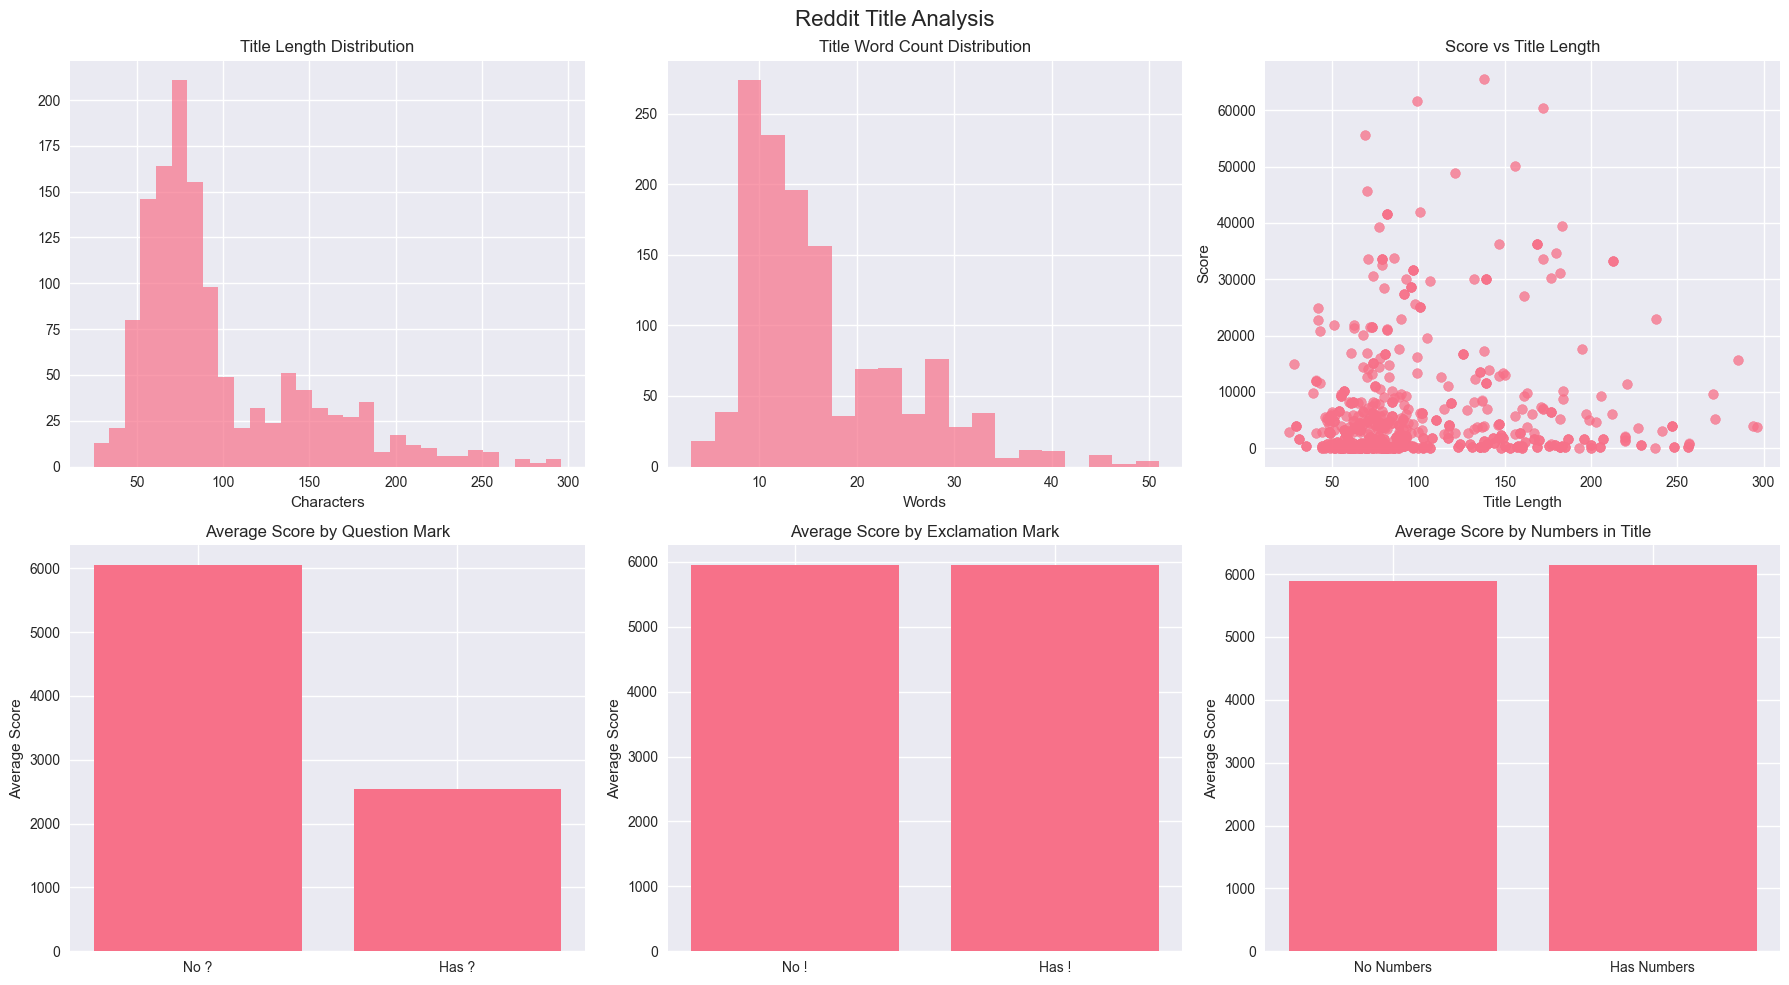


=== Reddit Sample Titles ===

Highest scoring titles:
Score 65560: Hackers Dox Hundreds of DHS, ICE, FBI, and DOJ Officials | Hackers posted phone numbers and addresse...
Score 65560: Hackers Dox Hundreds of DHS, ICE, FBI, and DOJ Officials | Hackers posted phone numbers and addresse...
Score 61660: President Publishes Enemies List To White House Website, And It’s Just Democrats Speaking The Truth...
Score 61660: President Publishes Enemies List To White House Website, And It’s Just Democrats Speaking The Truth...
Score 60471: ‘I love Hitler’: Leaked messages expose Young Republicans’ racist chat | Thousands of private messag...

Longest titles:
Length 296: A $60 Mod to Meta’s Ray-Bans Disables Its Privacy-Protecting Recording Light | Meta’s Ray-Ban glasse...
Length 296: A $60 Mod to Meta’s Ray-Bans Disables Its Privacy-Protecting Recording Light | Meta’s Ray-Ban glasse...
Length 294: 'Red Flag': Analysts Sound Major Alarms As AI Bubble Now 'Bigger' Than Subprime | Analysts published.

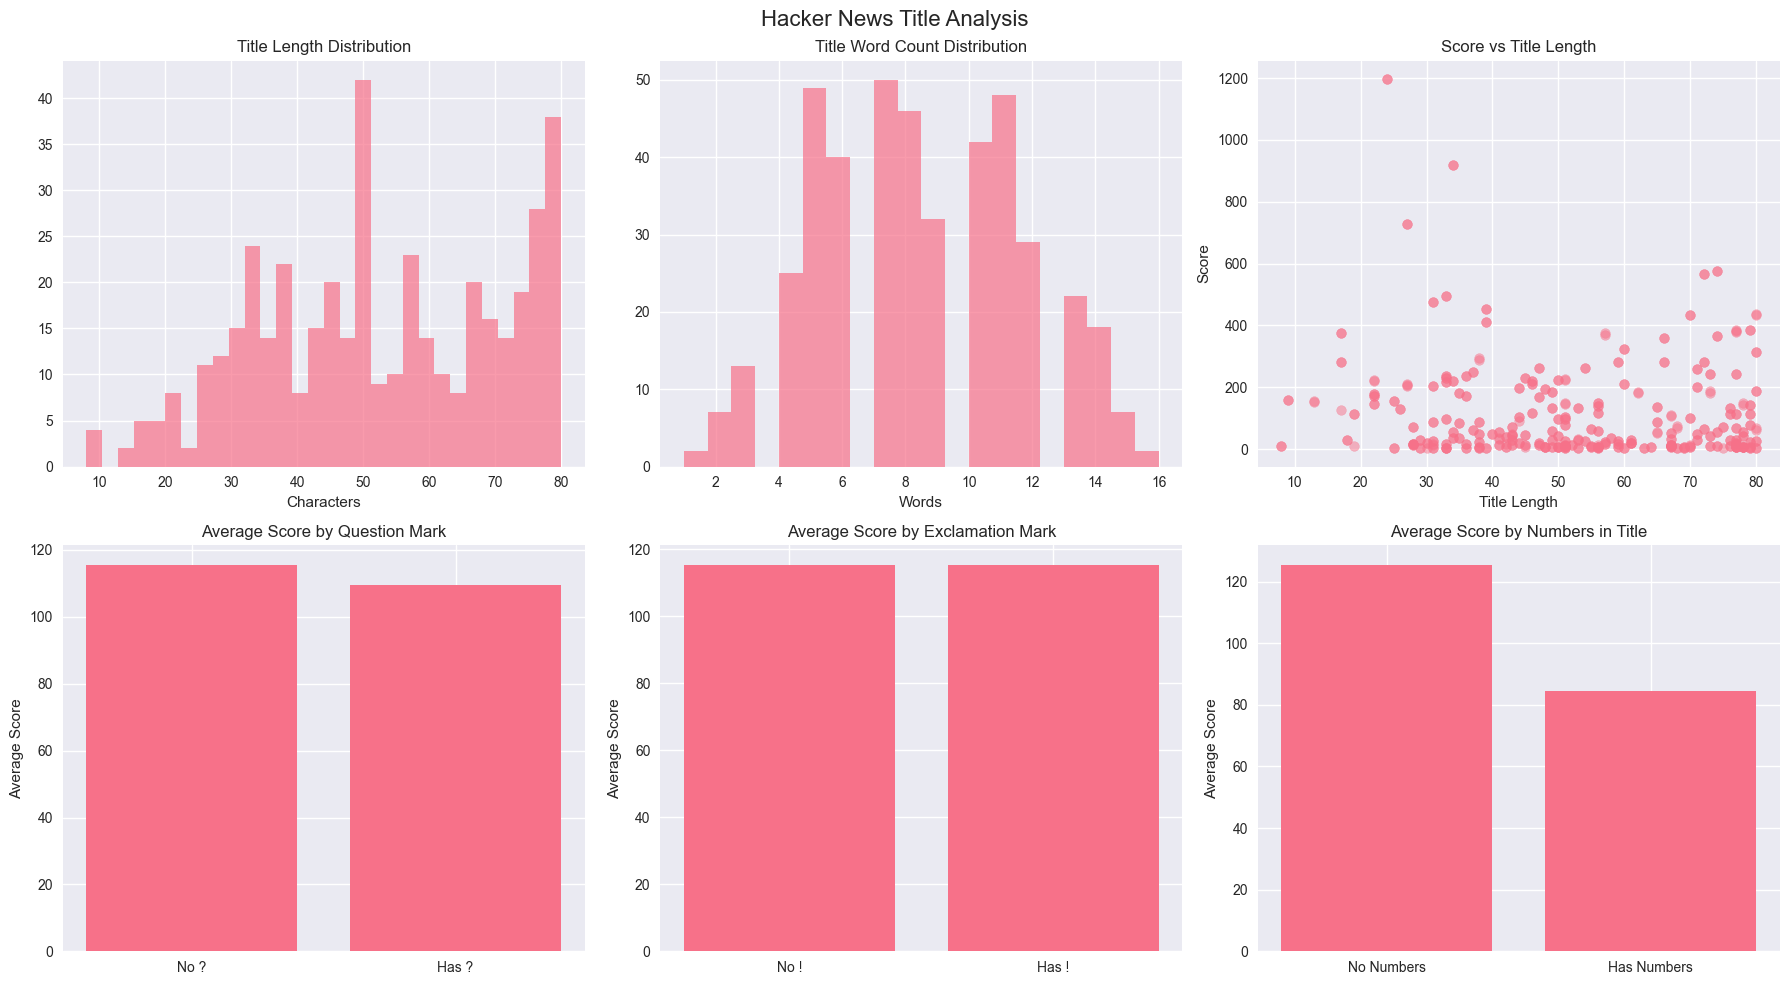


=== Hacker News Sample Titles ===

Highest scoring titles:
Score 1197: Affinity Studio now free...
Score 1197: Affinity Studio now free...
Score  919: Free software scares normal people...
Score  919: Free software scares normal people...
Score  728: Show HN: Strange Attractors...

Longest titles:
Length  80: Czech police forced to turn off facial recognition cameras at the Prague airport...
Length  80: You can't refuse to be scanned by ICE's facial recognition app, DHS document say...
Length  80: Ask HN: Who uses open LLMs and coding assistants locally? Share setup and laptop...


In [6]:
def analyze_titles(df, platform_name):
    """Analyze title patterns and their relationship to scores."""
    # Basic title statistics
    df = df.copy()
    df['title_length'] = df['title'].str.len()
    df['title_words'] = df['title'].str.split().str.len()
    df['has_question'] = df['title'].str.contains(r'\?').astype(int)
    df['has_exclamation'] = df['title'].str.contains(r'!').astype(int)
    df['has_numbers'] = df['title'].str.contains(r'\d').astype(int)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{platform_name} Title Analysis', fontsize=16)
    
    # Title length distribution
    axes[0, 0].hist(df['title_length'], bins=30, alpha=0.7)
    axes[0, 0].set_title('Title Length Distribution')
    axes[0, 0].set_xlabel('Characters')
    
    # Title words distribution
    axes[0, 1].hist(df['title_words'], bins=20, alpha=0.7)
    axes[0, 1].set_title('Title Word Count Distribution')
    axes[0, 1].set_xlabel('Words')
    
    # Score vs title length
    axes[0, 2].scatter(df['title_length'], df['score'], alpha=0.5)
    axes[0, 2].set_title('Score vs Title Length')
    axes[0, 2].set_xlabel('Title Length')
    axes[0, 2].set_ylabel('Score')
    
    # Question marks impact
    question_scores = df.groupby('has_question')['score'].mean()
    axes[1, 0].bar(['No ?', 'Has ?'], question_scores.values)
    axes[1, 0].set_title('Average Score by Question Mark')
    axes[1, 0].set_ylabel('Average Score')
    
    # Exclamation marks impact
    excl_scores = df.groupby('has_exclamation')['score'].mean()
    axes[1, 1].bar(['No !', 'Has !'], excl_scores.values)
    axes[1, 1].set_title('Average Score by Exclamation Mark')
    axes[1, 1].set_ylabel('Average Score')
    
    # Numbers impact
    number_scores = df.groupby('has_numbers')['score'].mean()
    axes[1, 2].bar(['No Numbers', 'Has Numbers'], number_scores.values)
    axes[1, 2].set_title('Average Score by Numbers in Title')
    axes[1, 2].set_ylabel('Average Score')
    
    plt.tight_layout()
    plt.show()
    
    # Show some example titles
    print(f"\n=== {platform_name} Sample Titles ===")
    print("\nHighest scoring titles:")
    top_titles = df.nlargest(5, 'score')[['title', 'score']]
    for _, row in top_titles.iterrows():
        print(f"Score {row['score']:4.0f}: {row['title'][:100]}...")
    
    print("\nLongest titles:")
    long_titles = df.nlargest(3, 'title_length')[['title', 'title_length']]
    for _, row in long_titles.iterrows():
        print(f"Length {row['title_length']:3.0f}: {row['title'][:100]}...")

if reddit_df is not None:
    analyze_titles(reddit_df, 'Reddit')

if hn_df is not None:
    analyze_titles(hn_df, 'Hacker News')

## 6. Platform Comparison

=== Platform Comparison ===
                    Reddit  Hacker News
Total Posts        1315.00       432.00
Mean Score         5958.99       115.41
Median Score       1827.00        50.00
Mean Title Length    98.89        52.33
Mean Comments       394.36        70.04


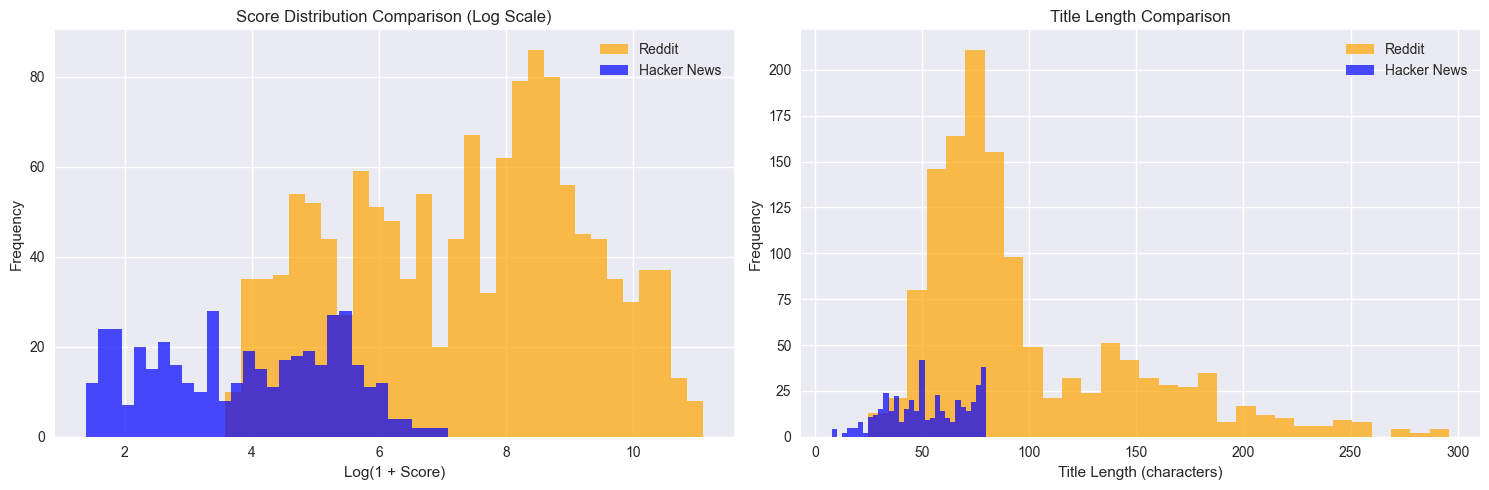

In [7]:
if reddit_df is not None and hn_df is not None:
    print("=== Platform Comparison ===")
    
    # Create comparison dataframe
    comparison = pd.DataFrame({
        'Reddit': [
            len(reddit_df),
            reddit_df['score'].mean(),
            reddit_df['score'].median(),
            reddit_df['title'].str.len().mean(),
            reddit_df['comment_count'].mean()
        ],
        'Hacker News': [
            len(hn_df),
            hn_df['score'].mean(),
            hn_df['score'].median(),
            hn_df['title'].str.len().mean(),
            hn_df['comment_count'].mean()
        ]
    }, index=['Total Posts', 'Mean Score', 'Median Score', 'Mean Title Length', 'Mean Comments'])
    
    print(comparison.round(2))
    
    # Side-by-side score distributions
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Log-scale comparison
    reddit_log = np.log1p(reddit_df['score'])
    hn_log = np.log1p(hn_df['score'])
    
    axes[0].hist(reddit_log, bins=30, alpha=0.7, label='Reddit', color='orange')
    axes[0].hist(hn_log, bins=30, alpha=0.7, label='Hacker News', color='blue')
    axes[0].set_title('Score Distribution Comparison (Log Scale)')
    axes[0].set_xlabel('Log(1 + Score)')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    
    # Title length comparison
    reddit_lengths = reddit_df['title'].str.len()
    hn_lengths = hn_df['title'].str.len()
    
    axes[1].hist(reddit_lengths, bins=30, alpha=0.7, label='Reddit', color='orange')
    axes[1].hist(hn_lengths, bins=30, alpha=0.7, label='Hacker News', color='blue')
    axes[1].set_title('Title Length Comparison')
    axes[1].set_xlabel('Title Length (characters)')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Need both Reddit and HN data for platform comparison")

## 7. Data Export Summary

In [8]:
print("=== Data Collection Summary ===")
print(f"Data directory: {data_dir.absolute()}")
print(f"Reddit files: {len(reddit_files)}")
print(f"HN files: {len(hn_files)}")

if reddit_df is not None:
    print(f"\nReddit data ready for feature engineering:")
    print(f"  - {len(reddit_df)} posts")
    print(f"  - Date range: {pd.to_datetime(reddit_df['created_timestamp'], unit='s').min()} to {pd.to_datetime(reddit_df['created_timestamp'], unit='s').max()}")

if hn_df is not None:
    print(f"\nHacker News data ready for feature engineering:")
    print(f"  - {len(hn_df)} stories")
    print(f"  - Date range: {pd.to_datetime(hn_df['created_timestamp'], unit='s').min()} to {pd.to_datetime(hn_df['created_timestamp'], unit='s').max()}")

print(f"\nNext steps:")
print(f"1. Run feature engineering: python bin/make_features.py")
print(f"2. Proceed to quality modeling (Stage A)")
print(f"3. Train residual lift models (Stage B)")

=== Data Collection Summary ===
Data directory: c:\Users\patri\OneDrive\Documents\RowanMastersClassesFiles\DataMining1\FinalProject\notebooks\..\data
Reddit files: 5
HN files: 3

Reddit data ready for feature engineering:
  - 1315 posts
  - Date range: 2025-10-02 23:39:47 to 2025-11-01 21:13:01

Hacker News data ready for feature engineering:
  - 432 stories
  - Date range: 2025-10-29 22:21:12 to 2025-11-01 22:05:00

Next steps:
1. Run feature engineering: python bin/make_features.py
2. Proceed to quality modeling (Stage A)
3. Train residual lift models (Stage B)
